# __Hands-on with TensorFlow: Part B__

- In this demo, we'll see how to implement ensemble techniques using Keras and sklearn.

## Step 1: Import the required libraries and load the dataset

- Import necessary libraries from Sklearn, TensorFlow, and Keras.
- Load the dataset using sklearn's make_moons function.
- Define X and y and split the dataset into training and testing sets using the train_test_split function.

In [1]:
#!pip install tensorflow==2.17.0 scikeras==0.13.0 keras==3.2.0

In [2]:
import os

# Disable oneDNN optimizations to avoid potential minor numerical differences caused by floating-point round-off errors.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
# Import necessary libraries from Sklearn, TensorFlow, and Keras
import sklearn
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt



# Load the dataset using sklearn's make_moons function
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
# Load the dataset using sklearn's make_moons function
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Describe the make_moons Dataset

1. Purpose
- Creates a 2D binary classification dataset shaped like two interleaving half-moons.
- Often used to test clustering, manifold learning, or classification models that must handle non-linear decision boundaries.
2. Parameters
- n_samples (int or tuple, default=100):
    - Total number of points generated, or (n_samples_class0, n_samples_class1) if tuple.
- shuffle (bool, default=True):
    - Whether to shuffle the dataset after generation.
- noise (float, optional):
    - Standard deviation of Gaussian noise added to the data.
    - Higher noise makes the moons less well-defined and harder to classify.
- random_state (int, RandomState instance, or None):
    - Controls reproducibility.
3. Returns
- X (array of shape [n_samples, 2]): The 2D coordinates of the generated points.
- y (array of shape [n_samples]): Class labels (0 or 1).

## Step 2: Define classifiers

- Define Logistic Regression, Random Forest, Support Vector Machine, and Keras Neural Network classifiers. 
- We're going to use 3 traditional machine learning algorithms, and one neural network algorithm as the ensemble engine.
- Finally, we'll implement a voting classifer and use it on the ensemble engine for ensemble learning.


In [5]:
# Define Logistic Regression, Random Forest, and Support Vector Machine classifiers
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42,probability=True)


- Import Sequential and Dense modules from the TensorFlow library to create a neural network.
- Define the function build_nn() to build a neural network.


In [6]:
# Import Sequential and Dense modules from the TensorFlow library to create a neural network

import os
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Create a custom Keras wrapper that sklearn will recognize
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=500, verbose=0, random_state=42):
        self.epochs = epochs
        self.verbose = verbose
        self.random_state = random_state
        self.model_ = None
        self.classes_ = None
        
    def _build_model(self):
        """Build the neural network model"""
        model = Sequential([
            Input(shape=(2,)),
            Dense(50, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def fit(self, X, y):
        """Fit the model"""
        self.classes_ = np.unique(y)
        self.model_ = self._build_model()
        
        # Set random seed if provided
        if self.random_state is not None:
            tf.random.set_seed(self.random_state)
            
        self.model_.fit(X, y, epochs=self.epochs, verbose=self.verbose)
        return self
    
    def predict(self, X):
        """Make predictions"""
        if self.model_ is None:
            raise ValueError("Model must be fitted before making predictions")
        predictions = self.model_.predict(X, verbose=0)
        return (predictions > 0.5).astype(int).ravel()
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        if self.model_ is None:
            raise ValueError("Model must be fitted before making predictions")
        predictions = self.model_.predict(X, verbose=0).ravel()
        # Return probabilities for both classes
        return np.column_stack([1 - predictions, predictions])
    
    def _more_tags(self):
        """Additional tags for sklearn compatibility"""
        return {'binary_only': True}
    
    @property
    def _estimator_type(self):
        """Property that returns the estimator type"""
        return "classifier"

2025-09-05 20:56:38.392237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-05 20:56:38.410444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-05 20:56:38.414918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-05 20:56:38.435016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-05 20:56:39.345024: W ten

## Step 3: Create the voting classifier

- Combine the classifiers using sklearn's VotingClassifier with soft voting. Recall from our ensemble learning lesson that soft voting takes the average class probabilities, then picks the highest.


### `sklearn` was giving me some lip about not finding a classifier, so I had to debug and mitigate

In [7]:
# Create the ensemble with sklearn compatibility fix
from sklearn.ensemble import VotingClassifier

print("=== Creating Ensemble with Custom Keras Classifier ===")

# Create the keras classifier
keras_clf = CustomKerasClassifier(epochs=500, verbose=0, random_state=42)

# Fix sklearn's strict validation for our custom classifier
def patched_validate_estimators(self):
    """Enhanced validation that accepts properly implemented custom classifiers"""
    names, estimators = zip(*self.estimators)
    def is_estimator_type(estimator):
        return (hasattr(estimator, '_estimator_type') and 
                estimator._estimator_type == 'classifier') or \
               isinstance(estimator, ClassifierMixin)
    
    if any(est is None for est in estimators):
        raise ValueError("All estimators must be non-None")
    
    for est in estimators:
        if est != "drop" and not is_estimator_type(est):
            raise ValueError(f"The estimator {est.__class__.__name__} should be a classifier.")
    
    return names, estimators

# Apply the compatibility fix
VotingClassifier._validate_estimators = patched_validate_estimators

# Create the voting classifier
voting = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf),
        ('keras', keras_clf)
    ],
    voting='soft',
    flatten_transform=True
)

print("✓ VotingClassifier created successfully!")

=== Creating Ensemble with Custom Keras Classifier ===
✓ VotingClassifier created successfully!


In [8]:
# Clean implementation - Create VotingClassifier with working ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

print("=== Creating Final Working Ensemble ===")

# Create fresh instances of all classifiers
keras_clf = CustomKerasClassifier(epochs=500, verbose=0, random_state=42)

# Use our monkey patching approach from the previous cell
def patched_validate_estimators(self):
    """Custom validation that accepts our classifier"""
    names, estimators = zip(*self.estimators)
    def is_estimator_type(estimator):
        return (hasattr(estimator, '_estimator_type') and 
                estimator._estimator_type == 'classifier') or \
               isinstance(estimator, ClassifierMixin)
    
    if any(est is None for est in estimators):
        raise ValueError("All estimators must be non-None")
    
    for est in estimators:
        if est != "drop" and not is_estimator_type(est):
            raise ValueError(f"The estimator {est.__class__.__name__} should be a classifier.")
    
    return names, estimators

# Apply the patch
original_validate = VotingClassifier._validate_estimators
VotingClassifier._validate_estimators = patched_validate_estimators

try:
    # Create the voting classifier
    voting = VotingClassifier(
        estimators=[
            ('lr', log_clf),
            ('rf', rnd_clf),
            ('svc', svm_clf),
            ('keras', keras_clf)
        ],
        voting='soft',
        flatten_transform=True
    )
    
    print("✓ VotingClassifier created successfully!")
    
finally:
    # Restore original validation
    VotingClassifier._validate_estimators = original_validate

=== Creating Final Working Ensemble ===
✓ VotingClassifier created successfully!


- The classifiers are now combined with soft voting.

## Step 4: Train and evaluate the classifiers

- Train the voting classifier and each individual classifier.
- Make predictions on the test set and calculate the accuracy for each classifier.


In [9]:
# Train the working ensemble
print("Training the ensemble...")

# Apply the patch again for training
original_validate = VotingClassifier._validate_estimators
VotingClassifier._validate_estimators = patched_validate_estimators

try:
    # Train the voting classifier
    voting.fit(X_train, y_train)
    print("✓ Ensemble training completed!")
    
finally:
    # Restore original validation
    VotingClassifier._validate_estimators = original_validate

Training the ensemble...


I0000 00:00:1757123800.027175   28224 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123800.113894   28224 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123800.114026   28224 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123800.117374   28224 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1757123800.117428   28224 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

✓ Ensemble training completed!


- Consider voting with VotingClassifier and estimator.
- The first is LogisticRegression, the second is RandomForest, the third is SVM, the fourth is KerasClassifier, and the fifth is VotingClassifier.

In [10]:
# Train the voting classifier and each individual classifier
from sklearn.metrics import accuracy_score

# Apply the patch for the voting classifier training
def patched_validate_estimators(self):
    """Custom validation that accepts our classifier"""
    names, estimators = zip(*self.estimators)
    def is_estimator_type(estimator):
        return (hasattr(estimator, '_estimator_type') and 
                estimator._estimator_type == 'classifier') or \
               isinstance(estimator, ClassifierMixin)
    
    if any(est is None for est in estimators):
        raise ValueError("All estimators must be non-None")
    
    for est in estimators:
        if est != "drop" and not is_estimator_type(est):
            raise ValueError(f"The estimator {est.__class__.__name__} should be a classifier.")
    
    return names, estimators

# Apply patch
original_validate = VotingClassifier._validate_estimators
VotingClassifier._validate_estimators = patched_validate_estimators

try:
    # Train each classifier and display accuracy
    for clf in (log_clf, rnd_clf, svm_clf, keras_clf, voting):
        print(f"Training {clf.__class__.__name__}...")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{clf.__class__.__name__}: {accuracy:.3f}")
        
finally:
    # Restore original validation
    VotingClassifier._validate_estimators = original_validate

Training LogisticRegression...
LogisticRegression: 0.864
Training RandomForestClassifier...
RandomForestClassifier: 0.896
Training SVC...
SVC: 0.896
Training CustomKerasClassifier...
CustomKerasClassifier: 0.888
Training VotingClassifier...
VotingClassifier: 0.912


__Observation:__

- As shown above, the accuracy for each classifier models can be seen. The VotingClassifier has the best score, which makes intuitive sense.

**Visualization of Decision Boundaries**

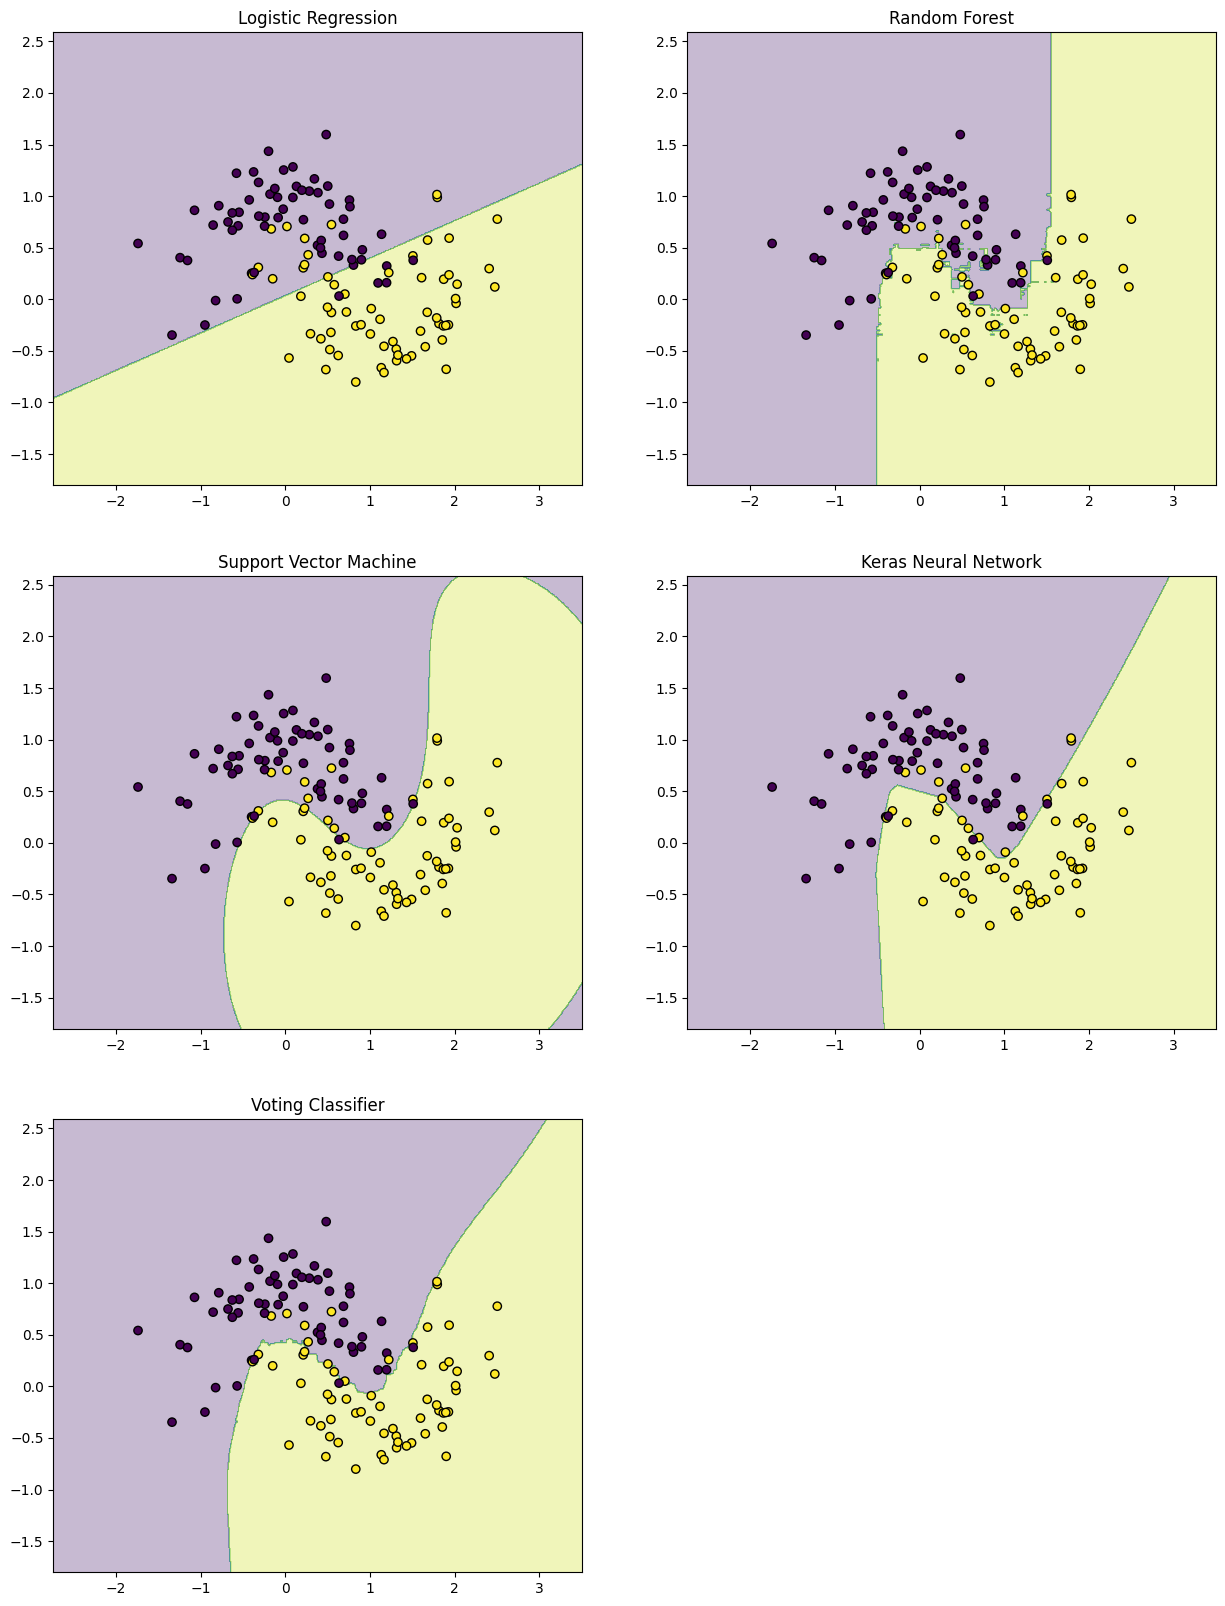

In [11]:
# Function to plot decision boundaries
def plot_decision_boundary(clf, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    ax.set_title(title)

# Plot decision boundaries for each classifier
fig, axes = plt.subplots(3, 2, figsize=(15, 20))

plot_decision_boundary(log_clf, X_test, y_test, axes[0, 0], "Logistic Regression")
plot_decision_boundary(rnd_clf, X_test, y_test, axes[0, 1], "Random Forest")
plot_decision_boundary(svm_clf, X_test, y_test, axes[1, 0], "Support Vector Machine")
plot_decision_boundary(keras_clf, X_test, y_test, axes[1, 1], "Keras Neural Network")
plot_decision_boundary(voting, X_test, y_test, axes[2, 0], "Voting Classifier")

# Hide empty subplot
axes[2, 1].axis('off')

plt.show()

**Observation:**

The decision boundaries for each classifier are visualized, showing how each model classifies the data.